Second part of laboratories were conducted by <a href="https://github.com/jarek-pawlowski">Jarosław Pawłowski</a>. He created notebooks we used in laboratories. I am really glad that I had him as a tutor.

In second course of ML/AI we were build ML models using pytorch.

In this notebook I will present only some task we had as a homework from notebook.

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128
# learning rate is how fast it will descend
model_args['lr'] = 2.e-4
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 50
# GAN parameters:
model_args['latent_space_dim'] = 100

print(torch.cuda.is_available())

True


In [4]:
# load the MINST dataset via torchvision
transform = transforms.ToTensor()
train_subset = datasets.MNIST('./data', train=True, download=True, transform=transform)

In [5]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'],
                 'num_workers': 6,
                 'pin_memory': True,
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reshape(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)

class GAN(nn.Module):
    # this defines the generator and discriminator structures
    def __init__(self, latent_space_dim):
        super(GAN, self).__init__()
        self.latent_space_dim = latent_space_dim

        self.generator = nn.Sequential(

            nn.Linear(self.latent_space_dim, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape(),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),

            Flatten(),

            nn.Linear(7*7*32, 1),
            #nn.Sigmoid()
        )

    def generator_forward(self, z):
        return self.generator(z)

    def discriminator_forward(self, img):
        return self.discriminator(img).view(-1)


In [7]:
def train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number, latent_space_dim):
    model.train()
    gen_losses = []
    dis_losses = []
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, _) in enumerate(train_loader):
        # normalize images to [-1, 1] range
        data = data*2. - 1.
        batch_size = data.size(0)
        # send data tensors to GPU (or CPU)
        data = data.to(device)
        # labels for training discriminator
        valid = torch.ones(batch_size).float().to(device)
        fake = torch.zeros(batch_size).float().to(device)
        # --------------------------
        # Train Generator
        # --------------------------
        # this will zero out the gradients for this batch
        optimizer_gen.zero_grad()
        # generate new images from noise
        z = torch.zeros((batch_size, latent_space_dim)).uniform_(-1.0, 1.0).to(device)
        generated_images = model.generator_forward(z)
        # loss for fooling the discriminator
        dis_predictions = model.discriminator_forward(generated_images.view(batch_size, 1, 28, 28))
        #
        gen_loss = F.binary_cross_entropy_with_logits(dis_predictions, valid) # not fooling D increases G loss
        gen_loss.backward()
        optimizer_gen.step()
        gen_losses.append(gen_loss.item())
        # --------------------------
        # Train Discriminator
        # --------------------------
        # this will zero out the gradients for this batch
        optimizer_dis.zero_grad()
        # D predictions for real images
        dis_predictions_real = model.discriminator_forward(data.view(batch_size, 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(dis_predictions_real, valid) # D should classify real as valid
        # D predictions for generated images
        dis_predictions_fake = model.discriminator_forward(generated_images.view(batch_size, 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(dis_predictions_fake, fake) # D should classify generated as fake
        #
        dis_loss = 0.5*(real_loss + fake_loss)
        dis_loss.backward()
        optimizer_dis.step()
        dis_losses.append(dis_loss.item())

    return gen_losses, dis_losses


def plot_loss(gen_loss, dis_loss, title=None):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('loss')
    xlabels = np.linspace(0, model_args['epochs'], num=len(gen_loss), endpoint=True)
    plt.plot(xlabels, gen_loss, label='generator')
    plt.plot(xlabels, dis_loss, label='discriminator')
    plt.legend()
    if title is not None: plt.title(title)
    plt.show()

## Tasks to do
* what if we increase/decrease the latent space size;
* please observe what will happen to generated image if we make a continuous transition (vector space arithmetic) between two given configurations in the latent space;

## Increase latent space

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAN(2*model_args['latent_space_dim']).to(device)
print(model)

optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=model_args['lr'])
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=model_args['lr'])

GAN(
  (generator): Sequential(
    (0): Linear(in_features=200, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 1

In [9]:
model = model.to(device)
summary(model.generator, input_size=(200,))
summary(model.discriminator, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         627,200
       BatchNorm1d-2                 [-1, 3136]           6,272
         LeakyReLU-3                 [-1, 3136]               0
           Reshape-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 13, 13]          18,432
       BatchNorm2d-6           [-1, 32, 13, 13]              64
         LeakyReLU-7           [-1, 32, 13, 13]               0
   ConvTranspose2d-8           [-1, 16, 25, 25]           4,608
       BatchNorm2d-9           [-1, 16, 25, 25]              32
        LeakyReLU-10           [-1, 16, 25, 25]               0
  ConvTranspose2d-11            [-1, 8, 27, 27]           1,152
      BatchNorm2d-12            [-1, 8, 27, 27]              16
        LeakyReLU-13            [-1, 8, 27, 27]               0
  ConvTranspose2d-14            [-1, 1,

C:\Users\Michal\PycharmProjects\ecg_class\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch 1 | Generator loss = 2.0345 | Discriminator loss = 0.1683
Train Epoch 2 | Generator loss = 2.6144 | Discriminator loss = 0.1059
Train Epoch 3 | Generator loss = 2.0518 | Discriminator loss = 0.1821
Train Epoch 4 | Generator loss = 1.8387 | Discriminator loss = 0.2396
Train Epoch 5 | Generator loss = 1.6701 | Discriminator loss = 0.2791
Train Epoch 6 | Generator loss = 1.5708 | Discriminator loss = 0.3221
Train Epoch 7 | Generator loss = 1.4347 | Discriminator loss = 0.3703
Train Epoch 8 | Generator loss = 1.3581 | Discriminator loss = 0.4093
Train Epoch 9 | Generator loss = 1.3013 | Discriminator loss = 0.4351
Train Epoch 10 | Generator loss = 1.2365 | Discriminator loss = 0.4690
Train Epoch 11 | Generator loss = 1.1861 | Discriminator loss = 0.4861
Train Epoch 12 | Generator loss = 1.1552 | Discriminator loss = 0.5006
Train Epoch 13 | Generator loss = 1.1385 | Discriminator loss = 0.5093
Train Epoch 14 | Generator loss = 1.1145 | Discriminator loss = 0.5177
Train Epoch 15 

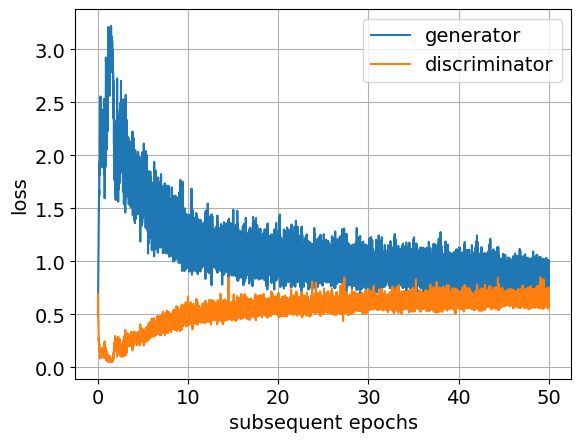

In [10]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number, 2*model_args['latent_space_dim'])
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

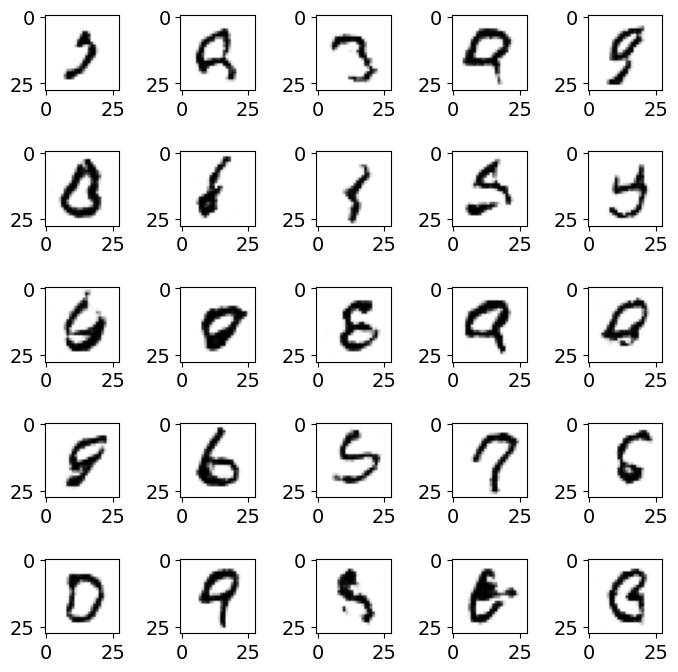

In [11]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim']*2)).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')


# Decrease latent space

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAN(int(model_args['latent_space_dim']/2)).to(device)
print(model)

optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=model_args['lr'])
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=model_args['lr'])

GAN(
  (generator): Sequential(
    (0): Linear(in_features=50, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 1,

In [13]:
model = model.to(device)
summary(model.generator, input_size=(50,))
summary(model.discriminator, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         156,800
       BatchNorm1d-2                 [-1, 3136]           6,272
         LeakyReLU-3                 [-1, 3136]               0
           Reshape-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 13, 13]          18,432
       BatchNorm2d-6           [-1, 32, 13, 13]              64
         LeakyReLU-7           [-1, 32, 13, 13]               0
   ConvTranspose2d-8           [-1, 16, 25, 25]           4,608
       BatchNorm2d-9           [-1, 16, 25, 25]              32
        LeakyReLU-10           [-1, 16, 25, 25]               0
  ConvTranspose2d-11            [-1, 8, 27, 27]           1,152
      BatchNorm2d-12            [-1, 8, 27, 27]              16
        LeakyReLU-13            [-1, 8, 27, 27]               0
  ConvTranspose2d-14            [-1, 1,

Train Epoch 1 | Generator loss = 1.3367 | Discriminator loss = 0.3661
Train Epoch 2 | Generator loss = 1.0363 | Discriminator loss = 0.4906
Train Epoch 3 | Generator loss = 1.1052 | Discriminator loss = 0.4599
Train Epoch 4 | Generator loss = 1.0379 | Discriminator loss = 0.5154
Train Epoch 5 | Generator loss = 1.0110 | Discriminator loss = 0.5298
Train Epoch 6 | Generator loss = 1.0073 | Discriminator loss = 0.5341
Train Epoch 7 | Generator loss = 0.9866 | Discriminator loss = 0.5502
Train Epoch 8 | Generator loss = 0.9662 | Discriminator loss = 0.5665
Train Epoch 9 | Generator loss = 0.9571 | Discriminator loss = 0.5749
Train Epoch 10 | Generator loss = 0.9355 | Discriminator loss = 0.5888
Train Epoch 11 | Generator loss = 0.9227 | Discriminator loss = 0.5932
Train Epoch 12 | Generator loss = 0.9127 | Discriminator loss = 0.5991
Train Epoch 13 | Generator loss = 0.9025 | Discriminator loss = 0.6027
Train Epoch 14 | Generator loss = 0.8973 | Discriminator loss = 0.6062
Train Epoch 15 

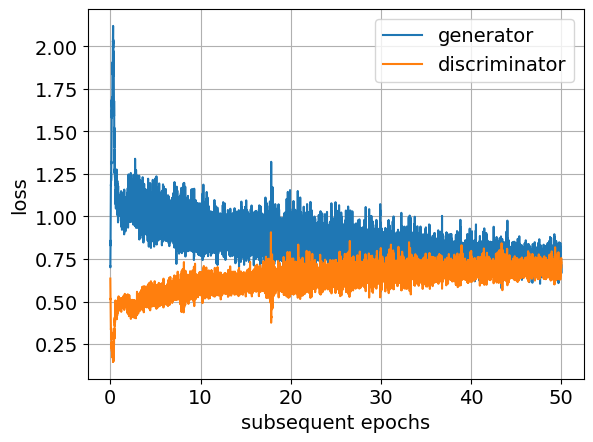

In [14]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number, int(model_args['latent_space_dim']/2))
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

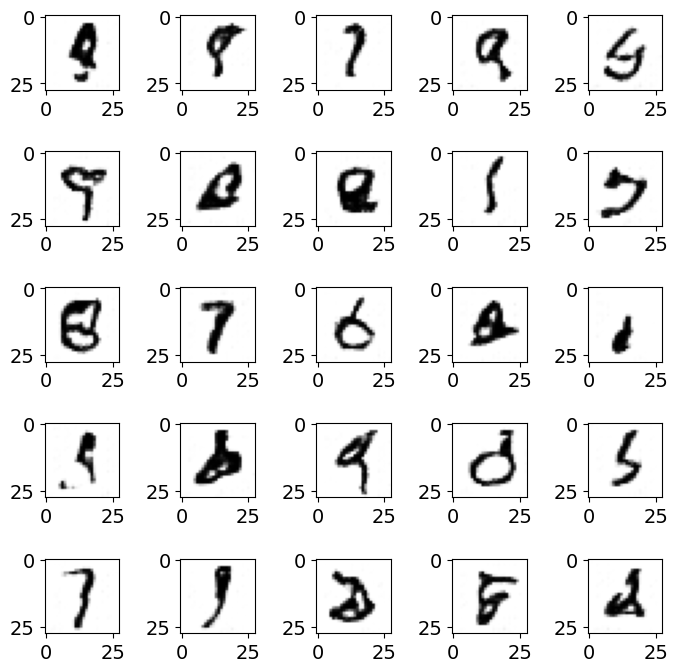

In [15]:
model.eval()

z = torch.zeros((25, int(model_args['latent_space_dim']/2))).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')